* ~~TODO: check that omnical and my version give the same answers~~
* TODO: look at data *7678
* TODO: try applying frequency n's degenercy correction (tip tilt) to frequency (n+1)'s first, then do the unwrapping again.
* TODO: try introducing a big phase slope (in frequency) halfway through the frequency band
* TODO: try introducing large phase slopes into the gains themselves

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import aipy as a 
import capo
import capo.miriad as miriad
from scipy.sparse import csr_matrix
from tqdm import tqdm
import capo.omni as omni
%matplotlib notebook 

# Array Classes

In [4]:
class InterferometricArray():
    """Class that takes a list of positions and can calcuate baselines and redundancies."""
    
    def __init__(self, positions=[]):
        self.positions = np.array(positions)
        self.nant = len(positions)
    
    def CalculateUBLs(self, precisionFactor=1000000):
        """Finds the baselines, unique baselines, and related dictionaries for indexing."""
        self.blVectors, self.blPairs = [], []
        for ant1 in range(self.nant):
            for ant2 in range(ant1+1,self.nant):
                delta = np.array([int(np.round(precisionFactor*(self.positions[ant1][i] - self.positions[ant2][i]))) for i in range(3)])
                if delta[1] > 0 or (delta[1] == 0 and delta[0] > 0): 
                    self.blVectors.append(tuple(delta))
                    self.blPairs.append((ant1, ant2))
                else: 
                    self.blVectors.append(tuple(-delta))
                    self.blPairs.append((ant2, ant1))
        self.ublDict = {}
        for b in range(len(self.blVectors)):
            if self.ublDict.has_key(self.blVectors[b]): self.ublDict[self.blVectors[b]].append(self.blPairs[b])
            else: self.ublDict[self.blVectors[b]] = [self.blPairs[b]]
        self.blIndexDict = {antPair: i for i,antPair in enumerate(self.blPairs)}
        self.ublIndexDict = {antPair: i for i,antPairs in enumerate(self.ublDict.values()) for antPair in antPairs }
        self.ublVectors = np.array([self.positions[antList[0][0]]-self.positions[antList[0][1]] for antList in self.ublDict.values()])
        self.ublGroups = [antList for antList in self.ublDict.values()]
        print "With", len(self.positions), "antennas there are", len(self.ublDict.items()), "unique baselines."
        self.nbl, self.nubl = len(self.blPairs), len(self.ublVectors)

class HexagonalArray(InterferometricArray):
    """Generates a hexagonal array."""
    
    def __init__(self, separation, hexNum, verbose=False):
        """Creates a hexagonal array with hexNum antennas per side separated by separation."""
        self.hexNum, self.separation, self.verbose = hexNum, separation, verbose
        positions, self.rowIndices, i = [], [], 0        
        for row in range(hexNum-1,-(hexNum),-1):
            indices = []
            for col in range(2*hexNum-abs(row)-1):
                xPos = ((-(2*hexNum-abs(row))+2)/2.0 + col)*separation;
                yPos = row*separation*3**.5/2;
                positions.append([xPos, yPos, 0])
                indices.append(i); i+=1
            self.rowIndices.append(indices)
        self.positions = np.array(positions) 
        self.nant = len(self.positions)

class InterferometricArrayFromAA(InterferometricArray):
    
    def __init__(self, aa, xants=[]):
        self.positions = np.array([pos for i,pos in enumerate(aa.antpos_ideal) if pos[2] != -1.0 and i not in xants])
        self.antNames = [i for i,pos in enumerate(aa.antpos_ideal) if pos[2] != -1.0 and i not in xants]
        self.nant = len(self.positions)
        self.index2name = {i:name for i,name in enumerate(self.antNames)}
        self.name2index = {name:i for i,name in enumerate(self.antNames)}
    

# Omnicalibrator Class

In [5]:
class OmniCalibrator():
    """This class contains method functions for the key steps in Omnical and stores relevant information about the array."""
    
    def __init__(self, array, verbose=True):
        self.a = array
        self.verbose = verbose
        antloc = np.array(self.a.positions); antloc[:,2] = 0
        R = np.array([np.append(ai,1) for ai in antloc]); #Get the R matrix. R = [r_i 1], where ri are the positions
        self.R2 = np.vstack((R, np.hstack((-self.a.ublVectors, np.zeros((self.a.nubl,1))))))
        self.M2 = np.linalg.pinv(self.R2.T.dot(self.R2)).dot(self.R2.T)
        return
    
    def ComputeErrors(self, obsVis, gainSols, visSols):
        """Computes the difference between the calibration model and the observation."""
        modelObs = np.array([gainSols[ant1] * np.conj(gainSols[ant2]) * visSols[self.a.ublIndexDict[(ant1,ant2)]] 
                             for (ant1,ant2),obs in zip(self.a.blPairs,obsVis)])
        return obsVis - modelObs

    def PerChannelDegeneracyCorrection(self, gainSols, visSols, degenGains, degenVis):
        """This function fixes the gain and phase degeneracies on a per-channel basis. Vulnerable to phase wrapping and related problems."""
        newGainSols, newVisSols = gainSols.copy(), visSols.copy()

        #Fix amplitudes
        newGainSols = gainSols * np.exp(1.0j * (np.mean(np.angle(degenGains)) - np.mean(np.angle(newGainSols))))
        newGainSols = gainSols / np.mean(np.abs(gainSols)) * np.mean(np.abs(degenGains))
        newVisSols = visSols * np.mean(np.abs(gainSols))**2 / np.mean(np.abs(degenGains))**2
        
        #Fix phases
        fullPhaseDegen = self.R2.dot(self.M2)
        fullPhaseProj = np.eye(self.a.nant + self.a.nubl) - fullPhaseDegen
        newPhases = fullPhaseProj.dot(np.angle(np.append(newGainSols, newVisSols))) + fullPhaseDegen.dot(np.angle(np.append(degenGains,degenVis)))
        newSols = np.abs(np.append(newGainSols, newVisSols)) * np.exp(1.0j * newPhases)
        newGainSols, newVisSols = newSols[0:self.a.nant], newSols[self.a.nant:]
        return newGainSols, newVisSols
    
    def PerformLogcal(self, obsVis, degenGains, degenVis):
        """Performs logcal using obsVis and self.a. Degeneracies are fixed by using degenGains, degenVis."""
        Acoeffs, Bcoeffs, rowIndices, colIndices = [np.zeros(self.a.nbl*3) for i in range(4)]
        for n,(ant1,ant2) in enumerate(self.a.blPairs):
            rowIndices[3*n:3*n+3] = n
            colIndices[3*n:3*n+3] = [ant1, ant2, self.a.nant + self.a.ublIndexDict[(ant1,ant2)]]
            Acoeffs[3*n:3*n+3] = [1.0, 1.0, 1.0]
            Bcoeffs[3*n:3*n+3] = [1.0, -1.0, 1.0]

        logcalA = csr_matrix((Acoeffs,(rowIndices,colIndices)), shape=(self.a.nbl, self.a.nant + self.a.nubl))
        logcalB = csr_matrix((Bcoeffs,(rowIndices,colIndices)), shape=(self.a.nbl, self.a.nant + self.a.nubl))
        AtA = (logcalA.conj().T.dot(logcalA)).toarray()
        BtB = (logcalB.conj().T.dot(logcalB)).toarray()
        nZeroEigenvalues = [np.sum(np.abs(np.linalg.eigvals(XtX)<1e-10)) for XtX in [AtA, BtB]]
        if not nZeroEigenvalues == [1,3]: print 'WARNING: Array is not omnical-able.' 

        xReal = (np.linalg.pinv(AtA)).dot(logcalA.conj().T.dot(np.real(np.log(obsVis))))
        xImag = (np.linalg.pinv(BtB)).dot(logcalB.conj().T.dot(np.imag(np.log(obsVis))))
        xHat = np.exp(xReal + 1.0j*xImag)
        logcalGainSols, logcalVisSols = xHat[0:self.a.nant], xHat[self.a.nant:]        
        return self.PerChannelDegeneracyCorrection(logcalGainSols, logcalVisSols, degenGains, degenVis)
    
    def LincalAMatrix(self, gainSols, visSols, realImagMode=False):
        """Calculates A used for lincal as a compressed sparse row matrix."""
        Acoeffs, rowIndices, colIndices = [np.zeros(self.a.nbl*12) for i in range(3)]
        for n,(ant1,ant2) in enumerate(self.a.blPairs):
            rowIndices[12*n:12*n+6] = 2*n
            rowIndices[12*n+6:12*n+12] = 2*n+1
            ublIndex = self.a.ublIndexDict[(ant1,ant2)]
            colIndices[12*n:12*n+6] = [2*ant1, 2*ant1+1, 2*ant2, 2*ant2+1, 2*self.a.nant+2*ublIndex, 2*self.a.nant+2*ublIndex+1]
            colIndices[12*n+6:12*n+12] = [2*ant1, 2*ant1+1, 2*ant2, 2*ant2+1, 2*self.a.nant+2*ublIndex, 2*self.a.nant+2*ublIndex+1]
            if realImagMode: #Compute coefficients for Real/Imag version of lincal
                gi0V0 = gainSols[ant1] * visSols[ublIndex]
                gj0starV0 = np.conj(gainSols[ant2]) * visSols[ublIndex]
                gi0gj0star = gainSols[ant1] * np.conj(gainSols[ant2])
                Acoeffs[12*n:12*n+6] = [np.real(gj0starV0), -np.imag(gj0starV0), np.real(gi0V0), 
                                        np.imag(gi0V0), np.real(gi0gj0star), -np.imag(gi0gj0star)]
                Acoeffs[12*n+6:12*n+12] = [np.imag(gj0starV0), np.real(gj0starV0), np.imag(gi0V0), 
                                           -np.real(gi0V0), np.imag(gi0gj0star), np.real(gi0gj0star)]
            else: #Compute coefficients for Amp/Phase version of lincal
                gi0gj0star = gainSols[ant1] * np.conj(gainSols[ant2])
                gi0gj0starVij0 = gi0gj0star * visSols[ublIndex]
                Acoeffs[12*n:12*n+6] = [np.real(gi0gj0starVij0), -np.imag(gi0gj0starVij0), np.real(gi0gj0starVij0), 
                                        np.imag(gi0gj0starVij0), np.real(gi0gj0star), -np.imag(gi0gj0star)]
                Acoeffs[12*n+6:12*n+12] = [np.imag(gi0gj0starVij0), np.real(gi0gj0starVij0), np.imag(gi0gj0starVij0), 
                                           -np.real(gi0gj0starVij0), np.imag(gi0gj0star), np.real(gi0gj0star)]
        return csr_matrix((Acoeffs,(rowIndices,colIndices)), shape=(2*self.a.nbl, 2*self.a.nant + 2*self.a.nubl))
    

    def PerformLincal(self, obsVis, gainStart, visStart, degenGains, degenVis, realImagMode=False, maxIter=100, convCrit=1e-14, divCrit = 1e14):
        """Performs lincal, either in the amp/phase mode or the real/imag mode. Projects out degeneracies and replaces them."""
        gainSols, visSols = gainStart.copy(), visStart.copy()
        if self.verbose: print '\nNow performing Lincal using the', ('Amp/Phs','Re/Imag')[realImagMode], 'method...'
        startingChiSq = np.mean(np.abs(self.ComputeErrors(obsVis, gainSols, visSols))**2) #TODO: update with noise
    
        for iteration in range(maxIter):            
            #Do all the linear algebra
            A = self.LincalAMatrix(gainSols, visSols, realImagMode=realImagMode)
            AtA = (A.conj().T.dot(A)).toarray()
            error = self.ComputeErrors(obsVis, gainSols, visSols)
            y = np.dstack((np.real(error),np.imag(error))).flatten()
            xHat = np.linalg.pinv(AtA).dot(A.conj().T.dot(y))
            
            #Update solutions
            updates = xHat[0::2] + 1.0j*xHat[1::2]
            if realImagMode: newGainSols = gainSols + updates[0:self.a.nant]
            else: newGainSols = gainSols * (1.0+updates[0:self.a.nant])
            newVisSols = visSols + updates[self.a.nant:]

            #Fix degeneracies if things have gone haywire
            chiSq = np.mean(np.abs(self.ComputeErrors(obsVis, newGainSols, newVisSols))**2)
            if chiSq > startingChiSq:
                newGainSols, newVisSols = self.PerChannelDegeneracyCorrection(newGainSols, newVisSols, degenGains, degenVis)
            convergence = np.linalg.norm(np.append(newGainSols-gainSols,newVisSols-visSols)) / np.linalg.norm(np.append(newGainSols,newVisSols))
            if self.verbose: print iteration, ' -- chiSq =', chiSq, '    convCrit =', convergence
            
            #Check for convergence
            if chiSq/startingChiSq > divCrit or iteration == maxIter-1:
                print 'WARNING: Lincal in ' + ('Amp/Phs','Re/Imag')[realImagMode] + ' Mode did not converge in', iteration+1, 'iterations!'
                print '    Stopped at chiSq =', chiSq, '    convCrit =', convergence
                break
            if convergence < convCrit : 
                if self.verbose: print ('Amp/Phs','Re/Imag')[realImagMode] + ' Mode converged in', iteration+1, 'iterations.'
                if self.verbose: print '    Stopped at chiSq =', chiSq, '    convCrit =', convergence
                break
            gainSols, visSols = newGainSols, newVisSols
        
        return self.PerChannelDegeneracyCorrection(newGainSols, newVisSols, degenGains, degenVis)
    
    def OverallBandpassDegeneracyProjection(self, allGainSols, allVisSols, allGuessGains, allGuessVis):
        """This function corrects degeneracies, but only after unwrapping across all channels. """
        finalGainSols, finalVisSols, allDegenGains, allDegenVis = [np.array(this) for this in [allGainSols, allVisSols, allGuessGains, allGuessVis]]
        #overall phase unwrapping
        phaseShift = np.mean(np.unwrap(np.angle(finalGainSols).T).T,axis=1)
        for ant in range(self.a.nant): finalGainSols[:,ant] *= np.exp(-1.0j * phaseShift)

        #tip/tilt/phase unwrapping
        fullPhaseDegen = self.R2.dot(self.M2)
        fullPhaseProj = np.eye(self.a.nant + self.a.nubl) - fullPhaseDegen
        allDegens = []
        for chan in range(len(allGainSols)):
            unwrappedGainSols = np.array([np.unwrap(np.angle(finalGainSols[0:chan+1,ant]))[chan] for ant in range(self.a.nant)])
            unwrappedVisSols = np.array([np.unwrap(np.angle(finalVisSols[0:chan+1,ubl]))[chan] for ubl in range(self.a.nubl)])
            unwrappedDegenGains = np.array([np.unwrap(np.angle(np.array(allDegenGains)[0:chan+1,ant]))[chan] for ant in range(self.a.nant)])
            unwrappedDegenVis = np.array([np.unwrap(np.angle(np.array(allDegenVis)[0:chan+1,ubl]))[chan] for ubl in range(self.a.nubl)])
            
            newPhases = fullPhaseProj.dot(np.append(unwrappedGainSols, unwrappedVisSols))
            newPhases += fullPhaseDegen.dot(np.append(unwrappedDegenGains,unwrappedDegenVis))
            newSols = np.abs(np.append(finalGainSols[chan,:], finalVisSols[chan,:])) * np.exp(1.0j * newPhases)
            newGainSols, newVisSols = newSols[0:self.a.nant], newSols[self.a.nant:]
            finalGainSols[chan,:], finalVisSols[chan,:] = newGainSols, newVisSols
            
            #Figure out the degenerate part for everyone
            unwrappedGainSols = np.array([np.unwrap(np.angle(finalGainSols[0:chan+1,ant]))[chan] for ant in range(self.a.nant)])
            unwrappedVisSols = np.array([np.unwrap(np.angle(finalVisSols[0:chan+1,ubl]))[chan] for ubl in range(self.a.nubl)])
            allDegens.append(self.M2.dot(np.append(unwrappedGainSols, unwrappedVisSols)))

        #fix channel 0
        degeneratePart =  self.R2.dot(np.median(allDegens,axis=0))
        newPhases = fullPhaseProj.dot(np.append(np.angle(finalGainSols[0,:]), np.angle(finalVisSols[0,:])))
        newPhases += self.R2.dot(np.median(allDegens,axis=0))
        newSols = np.abs(np.append(finalGainSols[0,:], finalVisSols[0,:])) * np.exp(1.0j * newPhases)
        newGainSols, newVisSols = newSols[0:self.a.nant], newSols[self.a.nant:]
        finalGainSols[0,:], finalVisSols[0,:] = newGainSols, newVisSols
        return list(finalGainSols), list(finalVisSols)
    
    #FUNCTIONS FOR USING OMNICAL PACKAGE INSTEAD OF MY LINEAR ALGEBRA
    
    def obsVisToOmniData(self, obsVis):
        """TODO: document."""
        data = {}
        for n,bl in enumerate(self.a.blPairs):
            data[bl] = {'xx': np.array([obsVis[n]]).reshape((1,-1)).astype('complex64')}
        return data

    def omniToSols(self, g2, v2, omniData):
        """TODO: document."""
        gainSols = np.array([g2['x'][ant][0][0] for ant in range(self.a.nant)])
        visSols = np.zeros(self.a.nubl, dtype=complex)
        for n,blGroup in enumerate(self.a.ublGroups):
            bl = blGroup[0]
            if len(blGroup) == 1: visSols[n] = omniData[bl]['xx'][0][0] / gainSols[bl[0]] / np.conj(gainSols[bl[1]])
            elif self.bl2exemplar.has_key(bl): visSols[n] = v2['xx'][self.bl2exemplar[bl]][0][0] 
            elif self.bl2exemplar.has_key((bl[1],bl[0])): visSols[n] = np.conj(v2['xx'][self.bl2exemplar[(bl[1],bl[0])]][0][0])
            else: print "WARNING: CAN'T FIND THE APPROPRIATE BASELINE!!!"  
        return gainSols, visSols

    def solsToOmni(self, gainSols, visSols):
        """TODO: document."""
        g2 = {'x': {}}
        for ant in range(self.a.nant): g2['x'][ant] = gainSols[ant] * np.ones(shape=(1,1),dtype='complex64')

        v2 = {'xx': {}} 
        for n,blGroup in enumerate(self.a.ublGroups):
            if len(blGroup) > 1:
                bl = blGroup[0]
                if self.bl2exemplar.has_key(bl): v2['xx'][self.bl2exemplar[bl]] = visSols[n] * np.ones(shape=(1,1),dtype='complex64')
                elif self.bl2exemplar.has_key((bl[1],bl[0])): 
                    v2['xx'][self.bl2exemplar[(bl[1],bl[0])]] = np.ones(shape=(1,1),dtype='complex64') * np.conj(visSols[n])
                else: print "WARNING: CAN'T FIND THE APPROPRIATE BASELINE!!!"  
        return g2, v2


    def runOmnicalPackage(self, allObsVis, maxiter=500, removeDegen=False, initFromPrevChan=False, perChannelDegenCorrection=False, 
                          overallBandpassCorrection=False, allGuessGains=None, allGuessVis=None):
        """Runs the omnical package, using various options for degeneracy removal post-processing."""
        reds = omni.compute_reds(self.a.positions.size, 'x', self.a.positions)
        info = omni.RedundantInfo(self.a.nant)
        info.init_from_reds(reds, self.a.positions)
        self.bl2exemplar = {bl: blgroup[0] for blgroup in info.get_reds() for bl in blgroup}

        omnicalGainSols, omnicalVisSols = [], []
        prevGainSols, prevVisSols = None, None
        for chan in range(nchan):
            data = self.obsVisToOmniData(allObsVis[chan])
            g0 = {'x': {ant: np.ones(shape=(1,1),dtype='complex64') for ant in range(self.a.nant)}}
            if initFromPrevChan and prevGainSols is not None and prevVisSols is not None:
                prevg2, prevv2 = self.solsToOmni(prevGainSols, prevVisSols)
                m2, g2, v2 = omni.redcal(data, info, vis=prevv2, gains=prevg2, uselogcal=False, removedegen=removeDegen, maxiter=maxiter)
            else: 
                m1, g1, v1 = omni.redcal(data, info, gains=g0, removedegen=removeDegen, maxiter=maxiter)
                m2, g2, v2 = omni.redcal(data, info, vis=v1, gains=g1, uselogcal=False, removedegen=removeDegen, maxiter=maxiter)
            gainSols, visSols = self.omniToSols(g2, v2, data)
            #print m2['chisq'][0], m2['iter'][0]

            if perChannelDegenCorrection and allGuessGains is not None and allGuessVis is not None:
                guessGains, guessVis = allGuessGains[chan], allGuessVis[chan]
                gainSols, visSols = self.PerChannelDegeneracyCorrection(gainSols, visSols, guessGains, guessVis)
            prevGainSols, prevVisSols = gainSols, visSols
            omnicalGainSols.append(gainSols); omnicalVisSols.append(visSols)

        if overallBandpassCorrection and allGuessGains is not None and allGuessVis is not None:
            omnicalGainSols, omnicalVisSols = self.OverallBandpassDegeneracyProjection(omnicalGainSols, omnicalVisSols, allGuessGains, allGuessVis)

        print np.mean(np.abs(self.ComputeErrors(allObsVis[chan], omnicalGainSols[chan], omnicalVisSols[chan]))**2)
        return omnicalGainSols, omnicalVisSols



# Omnical Settings, Setup, and Simulation

In [6]:
#SETTINGS
np.random.seed(6)
noiseLevel = 0.0
gainLevel = .4 #exponential amplitude std
delayErrorLevel = 10.150 #in ns
nchan = 20
separation = 14.7
hexNum = 3
verbose = False

#Create array and channel independent quantities
ha = HexagonalArray(separation, hexNum, verbose=False)
ha.CalculateUBLs()
freqs = .1 + .1*np.arange(nchan)/nchan #in GHz
delayErrors = delayErrorLevel*np.random.randn(ha.nant) #in ns
gainAmplitudes = np.exp(gainLevel*np.random.randn(ha.nant))
overallVis = 1.0*(np.random.randn(ha.nubl) + 1.0j*np.random.randn(ha.nubl))


#overallVis = 0*overallVis +  1*np.exp(1.0j * ha.ublVectors.dot([0, 1.8, 0]))


#Create observation
allGains, allTrueVis, allObsVis = [], [], []
allGuessGains, allGuessVis = [], []
for chan in range(nchan):
    #Gains
    gains = gainAmplitudes * np.exp(2.0j*np.pi*delayErrors*(freqs[chan]))
    guessGains = np.ones_like(gains)
    allGains.append(gains); allGuessGains.append(guessGains)
    
    #Visibilities
    trueVis = overallVis.copy()
    guessVis = np.ones_like(trueVis) 
    #guessVis = overallVis.copy()
    allTrueVis.append(trueVis); allGuessVis.append(guessVis)
    
    #Simulate Observations
    noiselessVis = np.array([gains[ant1] * np.conj(gains[ant2]) * trueVis[ha.ublIndexDict[(ant1,ant2)]] for (ant1,ant2) in ha.blPairs])
    noise = noiseLevel*(np.random.randn(ha.nbl) + 1.0j*np.random.randn(ha.nbl))
    obsVis = np.array(noiselessVis) + noise
    allObsVis.append(obsVis)
    
cal = OmniCalibrator(ha, verbose=verbose)

With 19 antennas there are 30 unique baselines.


# Compare with Omnical Package

In [7]:

# aa = a.cal.get_aa('hsa7458_v001', freqs)
# info = omni.aa_to_info(aa, pols=['x'], ex_ants=[], crosspols=['xx'])
# reds = info.get_reds()
# ia = InterferometricArrayFromAA(aa, xants=[])
# ia.CalculateUBLs()

# for chan in range(nchan):
#     errors = []
#     for bl, thisDict in data.items():
#         obsVis = thisDict['xx'][0][chan]
#         gain1 = g2['x'][bl[0]][0][chan]
#         gain2 = g2['x'][bl[1]][0][chan]
#         if bl2exemplar.has_key(bl): visSol = v2['xx'][bl2exemplar[bl]][0][chan] 
#         elif bl2exemplar.has_key((bl[1],bl[0])): visSol = np.conj(v2['xx'][bl2exemplar[(bl[1],bl[0])]][0][chan])
#         else: visSol = obsVis/gain1/np.conj(gain2)
#         errors.append(obsVis - gain1*np.conj(gain2)*visSol)
#     #print 'chi^2 =', np.mean(np.abs(errors)**2)


In [8]:
omnicalGainSols, omnicalVisSols = cal.runOmnicalPackage(allObsVis, removeDegen=False)
omnicalGainSolsRD, omnicalVisSolsRD = cal.runOmnicalPackage(allObsVis, removeDegen=True)
omnicalGainSolsFixed, omnicalVisSolsFixed = cal.runOmnicalPackage(allObsVis, removeDegen=False, initFromPrevChan=True, perChannelDegenCorrection=True, 
                                                                  overallBandpassCorrection=True, allGuessGains=allGuessGains, allGuessVis=allGuessVis)

x
6.94514230962e-13
7.21991333511e-13
3.2387528692e-13


In [9]:
allGainSols, allVisSols, allGainSols2, allVisSols2  = [], [], [], []
trueDegens, inputDegens, outputDegens, outputDegens2 = [np.zeros((nchan,4)) for i in range(4)]

for chan in tqdm(range(nchan)):
    obsVis, guessGains, guessVis = allObsVis[chan], allGuessGains[chan], allGuessVis[chan]
    
    if chan==0: gainStart, visStart = cal.PerformLogcal(obsVis, guessGains, guessVis)        
    else: gainStart, visStart = allGainSols[chan-1], allVisSols[chan-1]
    gainSols, visSols = cal.PerformLincal(obsVis, gainStart, visStart, guessGains, guessVis, realImagMode=True, maxIter=100)
    
    if chan==0: gainStart, visStart = cal.PerformLogcal(obsVis, guessGains, guessVis)
    else: gainStart, visStart = allGainSols2[chan-1], allVisSols2[chan-1]
    gainSols2, visSols2 = cal.PerformLincal(obsVis, gainStart, visStart, guessGains, guessVis, realImagMode=False, maxIter=100)

    allGainSols.append(gainSols); allVisSols.append(visSols)
    allGainSols2.append(gainSols2); allVisSols2.append(visSols2)
    
allGainSols, allVisSols = cal.OverallBandpassDegeneracyProjection(allGainSols, allVisSols, allGuessGains, allGuessVis)
allGainSols2, allVisSols2 = cal.OverallBandpassDegeneracyProjection(allGainSols2, allVisSols2, allGuessGains, allGuessVis)

print np.mean(np.abs(cal.ComputeErrors(obsVis, gainSols, visSols))**2)

100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


7.45578027454e-31


In [10]:
len(allObsVis)

20

<IPython.core.display.Javascript object>


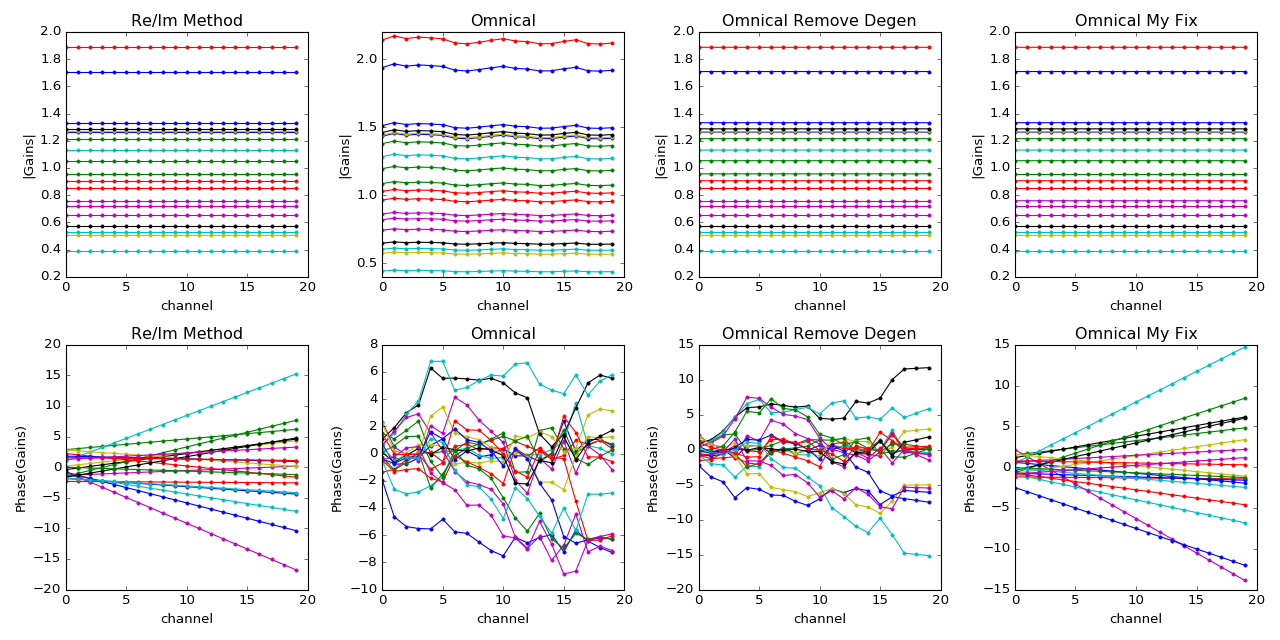

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(241)
plt.plot(np.abs(allGainSols),'.-');
plt.xlabel('channel'); plt.ylabel('|Gains|'); plt.title('Re/Im Method');

plt.subplot(242)
plt.plot(np.abs(omnicalGainSols),'.-');
plt.xlabel('channel'); plt.ylabel('|Gains|'); plt.title('Omnical');

plt.subplot(243)
plt.plot(np.abs(omnicalGainSolsRD),'.-');
plt.xlabel('channel'); plt.ylabel('|Gains|'); plt.title('Omnical Remove Degen');

plt.subplot(244)
plt.plot(np.abs(omnicalGainSolsFixed),'.-');
plt.xlabel('channel'); plt.ylabel('|Gains|'); plt.title('Omnical My Fix');

plt.subplot(245)
plt.plot(np.unwrap(np.angle(allGainSols).T).T,'.-');
plt.xlabel('channel'); plt.ylabel('Phase(Gains)'); plt.title('Re/Im Method');

plt.subplot(246)
plt.plot(np.unwrap(np.angle(omnicalGainSols).T).T,'.-');
plt.xlabel('channel'); plt.ylabel('Phase(Gains)'); plt.title('Omnical');

plt.subplot(247)
plt.plot(np.unwrap(np.angle(omnicalGainSolsRD).T).T,'.-');
plt.xlabel('channel'); plt.ylabel('Phase(Gains)'); plt.title('Omnical Remove Degen');

plt.subplot(248)
plt.plot(np.unwrap(np.angle(omnicalGainSolsFixed).T).T,'.-');
plt.xlabel('channel'); plt.ylabel('Phase(Gains)'); plt.title('Omnical My Fix');


plt.tight_layout()



<IPython.core.display.Javascript object>


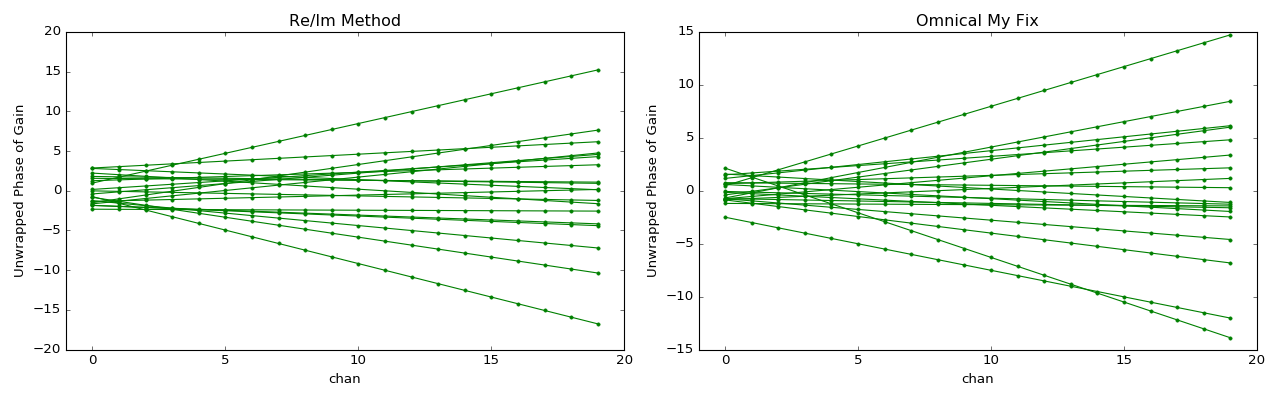

In [17]:
allGains = allGainSols
plt.figure(figsize=(16,5))

for allGains, sp, title in zip([allGainSols, omnicalGainSolsFixed],[121,122],['Re/Im Method', 'Omnical My Fix']):
    plt.subplot(sp)
    for ant in range(ha.nant):
        linfit = np.polyval(np.polyfit(range(1,nchan-1), np.unwrap(np.angle(allGains).T).T[1:nchan-1,ant], 1), range(nchan))
        plt.plot(np.unwrap(np.angle(allGains).T).T[:,ant],'g.')
        plt.plot(linfit,'g')
        error = np.unwrap(np.angle(allGains).T).T[:,ant] - linfit
        if np.linalg.norm(error) > 1e-6:
            if noiseLevel == 0: print 'Error in Antenna', ant, 'Channels:', np.where(np.abs(error) > 1e-6)[0]
            plt.plot(linfit,'r')
    plt.title(title)
    plt.xlabel('chan'), plt.ylabel('Unwrapped Phase of Gain')
    plt.xlim([-1, nchan])
plt.tight_layout()

# Use Real Data

In [18]:
aa = a.cal.get_aa('hsa7458_v001', freqs)
ia = InterferometricArrayFromAA(aa, xants=[])#[22,81])
ia.CalculateUBLs()


With 19 antennas there are 30 unique baselines.


What Aaron did:

zen.2457678.39660.xx.HH.uvc
yy
firstcal -C hsa calfile -p yy --ex_ant=81 *yy.HH.uvc
omni_run.py -C calfile -p yy --ba=81 --fc2=[firstcal output] [same file]
use capo.xrfi.omni_chi_2_to_flags (or something similar)

In [21]:
meta,data,flags = miriad.read_files(['zen.2457678.39660.xx.HH.uvc'],'cross','xx')
m,g,v,x = omni.from_npz('zen.2457678.39660.xx.HH.uvc.fc.npz')
aa = a.cal.get_aa('hsa7458_v001', meta['freqs'])
info = omni.aa_to_info(aa, pols=['x'], ex_ants=[], crosspols=['xx'])
reds = info.get_reds()

m1, g1, v1 = omni.redcal(data, info, gains=g, removedegen=False, maxiter=50)
m2, g2, v2 = omni.redcal(data, info, vis=v1, gains=g1, uselogcal=False, removedegen=False, maxiter=50)

#capo.

In [23]:
v2['xx'].keys()

[(43, 105),
 (31, 112),
 (10, 88),
 (9, 80),
 (72, 104),
 (43, 53),
 (10, 105),
 (96, 97),
 (31, 105),
 (9, 112),
 (9, 31),
 (10, 22),
 (22, 96),
 (31, 97),
 (64, 97),
 (9, 20),
 (43, 72),
 (9, 105),
 (20, 72),
 (10, 72),
 (9, 64),
 (80, 112),
 (9, 97),
 (53, 97),
 (65, 72),
 (9, 81),
 (10, 64)]

In [ ]:
POL_TYPES = 'xylrab'
#XXX this can't support restarts or changing # pols between runs
POLNUM = {} # factor to multiply ant index for internal ordering, 
NUMPOL = {}


def add_pol(p):
    global NUMPOL
    assert(p in POL_TYPES)
    POLNUM[p] = len(POLNUM)
    NUMPOL = dict(zip(POLNUM.values(), POLNUM.keys()))
    
class Antpol:
    def __init__(self, *args):
        try:
            ant,pol,nant = args
            if not POLNUM.has_key(pol): 
                print pol
                add_pol(pol)
            self.val, self.nant = POLNUM[pol] * nant + ant, nant
        except(ValueError): self.val, self.nant = args
    def antpol(self): return self.val % self.nant, NUMPOL[self.val / self.nant]
    def ant(self): return self.antpol()[0]
    def pol(self): return self.antpol()[1]
    def __int__(self): return self.val
    def __hash__(self): return self.ant()
    def __str__(self): return ''.join(map(str, self.antpol()))
    def __eq__(self, v): return self.ant() == v
    def __repr__(self): return str(self)

def aa_to_info(aa, pols=['x'], fcal=False, **kwargs):
    '''Use aa.ant_layout to generate redundances based on ideal placement.
        The remaining arguments are passed to omnical.arrayinfo.filter_reds()'''
    nant = len(aa)
    try:
        antpos_ideal = aa.antpos_ideal
        xs,ys,zs = antpos_ideal.T
        layout = np.arange(len(xs))
        #antpos = np.concatenat([antpos_ideal for i in len(pols)])
    except(AttributeError):
        layout = aa.ant_layout
        xs,ys = np.indices(layout.shape)
    antpos = -np.ones((nant*len(pols),3)) #remake antpos with pol information. -1 to flag
    for ant,x,y in zip(layout.flatten(), xs.flatten(), ys.flatten()):
        for z, pol in enumerate(pols):
            z = 2**z
            i = Antpol(ant, pol, len(aa))
#            print pol
#            print i.val
            antpos[i,0], antpos[i,1], antpos[i,2] = x,y,z
    reds = compute_reds(nant, pols, antpos[:nant], tol=.1)
    ex_ants = [Antpol(i,nant).ant() for i in range(antpos.shape[0]) if antpos[i,0] == -1]
    kwargs['ex_ants'] = kwargs.get('ex_ants',[]) + ex_ants
    reds = filter_reds(reds, **kwargs)
    if fcal:
        info = FirstCalRedundantInfo(nant)
    else:
        info = RedundantInfo(nant)
    info.init_from_reds(reds,antpos)
    return info


info = aa_to_info(aa, pols=['y'], ex_ants=[], crosspols=['yy'])

In [ ]:
mask = capo.xrfi.omni_chisq_to_flags(m2['chisq'], sigl=2)
mask[:,0:100] = True
mask[:,800:] = True
print mask.shape
plt.figure()
#plt.imshow(1.0*mask,aspect='auto')
#capo.plot.waterfall(np.logical_not(mask) * data[(43,105)]['xx'],mx=0,drng=3)

In [ ]:
#print m2['chisq']
plt.figure()
plt.imshow(m2['chisq'],aspect='auto')


#capo.plot.waterfall(v2['xx'][(43, 105)],mode='phs')
#capo.plot.waterfall(g2['x'][(43)],mode='phs')
capo.plot.waterfall(data[(43,105)]['xx'],mx=1,drng=3)

In [ ]:
info,data,flags = miriad.read_files(['zen.2457678.38964.xx.HH.uvc'],'cross','xx') #same day as Aaron
#info,data,flags = miriad.read_files(['zen.2457780.40357.xx.HH.uvcF'],'cross','xx') 
#print data[(22,81)]['xx'].shape #[time][channel]
freqSelect = np.arange(300,320)
freqs = info['freqs'][freqSelect]
nchan = len(freqs)
time = 40
allObsVis = np.zeros((nchan,ia.nbl),dtype=complex)
for blIndex,(ant1,ant2) in enumerate(ia.blPairs):
    try: allObsVis[:,blIndex] = np.conj(data[(ia.index2name[ant1],ia.index2name[ant2])]['xx'][time,freqSelect])
    except: allObsVis[:,blIndex] = (data[(ia.index2name[ant2],ia.index2name[ant1])]['xx'][time,freqSelect])

freqSelect = np.arange(1024)
ublgroup = ia.ublDict.values()[1]
someObsVis = np.zeros((len(freqSelect),len(ublgroup)),dtype=complex)
for blIndex,(ant1,ant2) in enumerate(ublgroup):
    try: someObsVis[:,blIndex] = (data[(ia.index2name[ant1],ia.index2name[ant2])]['xx'][time,freqSelect])
    except: someObsVis[:,blIndex] = np.conj(data[(ia.index2name[ant2],ia.index2name[ant1])]['xx'][time,freqSelect])
        
        
plt.figure()
plt.plot(np.unwrap(np.angle(someObsVis)))
#plt.plot(np.abs(someObsVis))
plt.legend([(ia.index2name[ant1], ia.index2name[ant2]) for (ant1,ant2) in ublgroup])




In [ ]:
allGainSols, allVisSols, allGainSols2, allVisSols2  = [], [], [], []
trueDegens, inputDegens, outputDegens, outputDegens2 = [np.zeros((nchan,4)) for i in range(4)]

for chan in tqdm(range(nchan)):
    obsVis, guessGains, guessVis = allObsVis[chan], allGuessGains[chan], allGuessVis[chan]
    
    if chan==0: gainStart, visStart = cal.PerformLogcal(obsVis, guessGains, guessVis)        
    else: gainStart, visStart = allGainSols[chan-1], allVisSols[chan-1]
    gainSols, visSols = cal.PerformLincal(obsVis, gainStart, visStart, guessGains, guessVis, realImagMode=True, maxIter=100)
    
    if chan==0: gainStart, visStart = cal.PerformLogcal(obsVis, guessGains, guessVis)
    else: gainStart, visStart = allGainSols2[chan-1], allVisSols2[chan-1]
    gainSols2, visSols2 = cal.PerformLincal(obsVis, gainStart, visStart, guessGains, guessVis, realImagMode=False, maxIter=100)

    allGainSols.append(gainSols); allVisSols.append(visSols)
    allGainSols2.append(gainSols2); allVisSols2.append(visSols2)
    
allGainSols, allVisSols = cal.OverallBandpassDegeneracyProjection(allGainSols, allVisSols, allGuessGains, allGuessVis)
allGainSols2, allVisSols2 = cal.OverallBandpassDegeneracyProjection(allGainSols2, allVisSols2, allGuessGains, allGuessVis)

# Run My Omnical

In [ ]:
allGainSols, allVisSols, allGainSols2, allVisSols2  = [], [], [], []
trueDegens, inputDegens, outputDegens, outputDegens2 = [np.zeros((nchan,4)) for i in range(4)]

for chan in tqdm(range(nchan)):
    obsVis, guessGains, guessVis = allObsVis[chan], allGuessGains[chan], allGuessVis[chan]
    
    if chan==0: gainStart, visStart = guessGains, guessVis#cal.PerformLogcal(obsVis, guessGains, guessVis)        
    else: gainStart, visStart = allGainSols[chan-1], allVisSols[chan-1]
    gainSols, visSols = cal.PerformLincal(obsVis, gainStart, visStart, guessGains, guessVis, realImagMode=True, maxIter=100)
    
    if chan==0: gainStart, visStart = guessGains, guessVis#cal.PerformLogcal(obsVis, guessGains, guessVis)
    else: gainStart, visStart = allGainSols2[chan-1], allVisSols2[chan-1]
    gainSols2, visSols2 = cal.PerformLincal(obsVis, gainStart, visStart, guessGains, guessVis, realImagMode=False, maxIter=100)

    allGainSols.append(gainSols); allVisSols.append(visSols)
    allGainSols2.append(gainSols2); allVisSols2.append(visSols2)
    
allGainSols, allVisSols = cal.OverallBandpassDegeneracyProjection(allGainSols, allVisSols, allGuessGains, allGuessVis)
allGainSols2, allVisSols2 = cal.OverallBandpassDegeneracyProjection(allGainSols2, allVisSols2, allGuessGains, allGuessVis)

# Results Plotting

In [ ]:
chan = 0
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.quiver(np.real(allTrueVis[chan]), np.imag(allTrueVis[chan]), np.real(allVisSols[chan]-allTrueVis[chan]), 
           np.imag(allVisSols[chan]-allTrueVis[chan]), angles='xy', scale_units='xy', scale=1)
plt.plot(np.real(allTrueVis[chan]), np.imag(allTrueVis[chan]),'r.',label='True Visibilities')
plt.plot(np.real(allVisSols[chan]), np.imag(allVisSols[chan]),'b.',label='Calibrated Visibilities')
plt.title('Re/Im Method')
plt.legend(loc='best')
plt.subplot(122)
plt.quiver(np.real(allTrueVis[chan]), np.imag(allTrueVis[chan]), np.real(allVisSols2[chan]-allTrueVis[chan]), 
           np.imag(allVisSols2[chan]-allTrueVis[chan]), angles='xy', scale_units='xy', scale=1)
plt.plot(np.real(allTrueVis[chan]), np.imag(allTrueVis[chan]),'r.',label='True Visibilities')
plt.plot(np.real(allVisSols2[chan]), np.imag(allVisSols2[chan]),'b.',label='Calibrated Visibilities')
plt.title('Amp/Phase Method')
plt.legend(loc='best')

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.quiver(np.real(allGains[chan]), np.imag(allGains[chan]), np.real(allGainSols[chan]-allGains[chan]), 
           np.imag(allGainSols[chan]-allGains[chan]), angles='xy', scale_units='xy', scale=1)
plt.plot(np.real(allGains[chan]), np.imag(allGains[chan]),'r.',label='True Gains')
plt.plot(np.real(allGainSols[chan]), np.imag(allGainSols[chan]),'b.',label='Calibrated Gains')
plt.title('Re/Im Method')
plt.legend(loc='best')
plt.subplot(122)
plt.quiver(np.real(allGains[chan]), np.imag(allGains[chan]), np.real(allGainSols2[chan]-allGains[chan]), 
           np.imag(allGainSols2[chan]-allGains[chan]), angles='xy', scale_units='xy', scale=1)
plt.plot(np.real(allGains[chan]), np.imag(allGains[chan]),'r.',label='True Gains')
plt.plot(np.real(allGainSols2[chan]), np.imag(allGainSols2[chan]),'b.',label='Calibrated Gains')
plt.title('Amp/Phase Method')
plt.legend(loc='best')


In [ ]:
plt.figure()
plt.semilogy(range(nchan), [np.linalg.norm(visSols-trueVis) / np.linalg.norm(trueVis) for visSols,trueVis in zip(allVisSols, allTrueVis)],'r')
plt.semilogy(range(nchan), [np.linalg.norm(visSols-trueVis) / np.linalg.norm(trueVis) for visSols,trueVis in zip(allVisSols2, allTrueVis)],'b')
plt.semilogy(range(nchan), [np.linalg.norm(cal.ComputeErrors(allObsVis[chan], allGainSols[chan], allVisSols[chan])) / np.linalg.norm(allObsVis[chan]) for chan in range(nchan)],'r--')
plt.semilogy(range(nchan), [np.linalg.norm(cal.ComputeErrors(allObsVis[chan], allGainSols2[chan], allVisSols2[chan])) / np.linalg.norm(allObsVis[chan]) for chan in range(nchan)],'b--')

plt.legend(['Re/Im Method Vis Error', 'Amp/Phase Method Vis Error', 'Re/Im Method ChiSq', 'Amp/Phase Method ChiSq'], loc=0)
plt.xlabel('Channel'); plt.ylabel('Final Relative Error in Visibilities');

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(221)
plt.plot(np.abs(allGainSols),'.-');
plt.xlabel('channel'); plt.ylabel('|Gains|'); plt.title('Re/Im Method');

plt.subplot(222)
plt.plot(np.abs(allGainSols2),'.-');
plt.xlabel('channel'); plt.ylabel('|Gains|'); plt.title('Amp/Phase Method');

plt.subplot(223)
plt.plot(np.unwrap(np.angle(allGainSols).T).T,'.-');
plt.xlabel('channel'); plt.ylabel('Phase(Gains)'); plt.title('Re/Im Method');

plt.subplot(224)
plt.plot(np.unwrap(np.angle(allGainSols2).T).T,'.-');
plt.xlabel('channel'); plt.ylabel('Phase(Gains)'); plt.title('Amp/Phase Method');
plt.tight_layout()

In [ ]:
allGains = allGainSols
plt.figure()
for ant in range(ha.nant):
    linfit = np.polyval(np.polyfit(range(1,nchan-1), np.unwrap(np.angle(allGains).T).T[1:nchan-1,ant], 1), range(nchan))
    plt.plot(np.unwrap(np.angle(allGains).T).T[:,ant],'g.')
    plt.plot(linfit,'g')
    error = np.unwrap(np.angle(allGains).T).T[:,ant] - linfit
    if np.linalg.norm(error) > 1e-12:
        if noiseLevel == 0: print 'Error in Antenna', ant, 'Channels:', np.where(np.abs(error) > 1e-12)[0]
        plt.plot(linfit,'r')
plt.title('Green is a perfect linear match. Red is mismatched.')
plt.xlim([-1, nchan])

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)

allGains = allGainSols
#plt.plot(np.mean(np.unwrap(np.angle(newAllGainSols).T).T,axis=1))
#plt.plot(np.unwrap(np.angle(newAllGainSols).T).T)

plt.plot(np.mean(np.unwrap(np.angle(allGains).T).T,axis=1) / 2/np.pi*ha.nant,'b.-')
plt.plot(np.mean((np.angle(allGains).T).T,axis=1) / 2/np.pi*ha.nant,'g.-')
plt.legend(['Unwrapped', 'Wrapped'], loc=0)
plt.xlabel('Channel')
plt.ylabel('Mean Phase / ($2\pi$/$N_{ant}$)')

plt.subplot(122)
plt.plot((np.angle(allGains).T).T,'.-')
plt.xlabel('Channel')
plt.ylabel('Wrapped Phase of Each Antenna Gain')
plt.tight_layout()

# Old Code: A different approach to simulating gains as a function of frequency

In [ ]:
# ha = HexagonalArray(14.7, 3, verbose=False)
# ha.CalculateUBLs()

# nchan = 20
# freqs = .1 + .1*np.arange(nchan)/nchan #in GHz
# noiseLevel = .0
# gainLevel = .2 
# phaseLevel = .2

# trueCableLengths = .51*np.random.randn(ha.nant) #in ns
# #guessCableLengths = 50 + 10*np.random.randn(ha.nant) #in ns
# guessCableLenghts = trueCableLengths

# allGains, allTrueVis, allObsVis = [np.zeros((nchan,dim2),dtype=complex) for dim2 in (ha.nant, ha.nubl, ha.nbl)]
# firstCalGains, firstCalVis = [np.zeros((nchan,dim2),dtype=complex) for dim2 in (ha.nant, ha.nubl)]
# gains = np.exp(gainLevel*np.random.randn(ha.nant) + 1.0j * phaseLevel*np.random.randn(ha.nant))
# trueVis = 1.0*(np.random.randn(ha.nubl) + 1.0j*np.random.randn(ha.nubl))


# for chan in range(nchan):
#     gainsHere = gains * np.exp(2.0j*np.pi*trueCableLengths*freqs[chan])
#     gainsHere = np.exp(gainLevel*np.random.randn(ha.nant) + 1.0j * phaseLevel*np.random.randn(ha.nant))
#     trueVisHere = trueVis 
#     noiselessVis = np.array([gainsHere[ant1] * np.conj(gainsHere[ant2]) * trueVisHere[ha.ublIndexDict[(ant1,ant2)]] for (ant1,ant2) in ha.blPairs])
#     noise = noiseLevel*(np.random.randn(ha.nbl) + 1.0j*np.random.randn(ha.nbl))
#     obsVisHere = np.array(noiselessVis) + noise
#     allGains[chan,:], allTrueVis[chan,:], allObsVis[chan,:] = gainsHere, trueVisHere, obsVisHere
    
#     #firstCalGains[chan,:], firstCalVis[chan,:] = gains * np.exp(2.0j*np.pi*guessCableLengths*freqs[chan]), trueVis
#     firstCalGains[chan,:], firstCalVis[chan,:] = gains, trueVis
#     allGains[chan,:], allTrueVis[chan,:], allObsVis[chan,:] = ha.GenerateFakeObservation(noiseLevel=0.0, gainLevel=.2, phaseLevel=.2)


# freqs = .1 + .1*np.arange(nchan)/nchan #in GHz

# gains = np.exp(gainLevel*np.random.randn(ha.nant) + 1.0j * phaseLevel*np.random.randn(ha.nant))
# trueVis = 1.0*(np.random.randn(ha.nubl) + 1.0j*np.random.randn(ha.nubl))

# allGains, allTrueVis, allObsVis = [], [], []#[np.zeros((nchan,dim2),dtype=complex) for dim2 in (ha.nant, ha.nubl, ha.nbl)]
# for chan in range(nchan):
#     gainsHere = gains.copy() 
# #    gainsHere = np.exp(gainLevel*np.random.randn(ha.nant) + 1.0j * phaseLevel*np.random.randn(ha.nant))
#     trueVisHere = trueVis.copy()
# #    trueVisHere = 1.0*(np.random.randn(ha.nubl) + 1.0j*np.random.randn(ha.nubl))
    
#     noiselessVis = np.array([gainsHere[ant1] * np.conj(gainsHere[ant2]) * trueVisHere[ha.ublIndexDict[(ant1,ant2)]] for (ant1,ant2) in ha.blPairs])
    
#     noise = noiseLevel*(np.random.randn(ha.nbl) + 1.0j*np.random.randn(ha.nbl))
    
#     obsVisHere = np.array(noiselessVis) + noise
#     allGains.append(gainsHere)
#     allTrueVis.append(trueVisHere)
#     allObsVis.append(obsVisHere)

# Old Code: Levenberg–Marquardt Lincal (seems unnecessary)

In [ ]:
#     def PerformLincal(self, obsVis, gainStart, visStart, degenGains, degenVis, realImagMode=False, maxIter=100, convCrit=1e-14):
#         """Performs lincal, either in the amp/phase mode or the real/imag mode. Projects out degeneracies and replaces them."""
#         gainSols, visSols = gainStart.copy(), visStart.copy()
#         if self.verbose and realImagMode: print '\nNow performing Lincal using the Real/Imag method...'
#         elif self.verbose: print '\nNow performing Lincal using the Amp/Phase method...'
#         dampingFactor, previousChiSq, previousStep = 1.0, 1e100, None
        
#         for iteration in range(maxIter):
            
#             A = self.LincalAMatrix(gainSols, visSols, realImagMode=realImagMode)
#             AtA = (A.conj().T.dot(A)).toarray()
#             error = self.ComputeErrors(obsVis, gainSols, visSols)
#             y = np.dstack((np.real(error),np.imag(error))).flatten()
            
#             while True:
#                 Proj, IMinusProj = self.DegeneracyProjectionMatrices(AtA)
#                 M = AtA + Proj.dot(dampingFactor * np.diag(np.diag(AtA)))
#                 xHat = np.linalg.pinv(M).dot(A.conj().T.dot(y))
                
#                 if realImagMode:
#                     xCurrent = np.dstack((np.real(np.append(gainSols, visSols)),np.imag(np.append(gainSols, visSols)))).flatten()
#                     xDegen = np.dstack((np.real(np.append(degenGains, degenVis)),np.imag(np.append(degenGains, degenVis)))).flatten()    
#                     xHat = Proj.dot(xHat) + IMinusProj.dot(xDegen - xCurrent) 
#                     updates = xHat[0::2] + 1.0j*xHat[1::2]
#                     newGainSols = gainSols + updates[0:self.a.nant]
#                     newVisSols = visSols + updates[self.a.nant:]
#                 else: 
#                     deltaGains = degenGains/gainSols
#                     deltaVis = degenVis - visSols
#                     deltax = np.dstack((np.append(np.abs(np.log(deltaGains)),np.real(deltaVis)), 
#                                         np.append(np.angle(deltaGains), np.imag(deltaVis)))).flatten()
#                     xHat = Proj.dot(xHat) + IMinusProj.dot(deltax)                  
#                     updates = xHat[0::2] + 1.0j*xHat[1::2]
#                     newGainSols = gainSols * (1.0+updates[0:self.a.nant])
#                     newVisSols = visSols + updates[self.a.nant:]
                
# #                 if dampingFactor < 1e-14:
# #                     print 'chisq before: ', np.mean(np.abs(self.ComputeErrors(obsVis, newGainSols, newVisSols))**2)
# #                     newGainSols, newVisSols = self.AbsoluteDegeneracyProjection(newGainSols, newVisSols, degenGains, degenVis)
# #                     print 'chisq after: ', np.mean(np.abs(self.ComputeErrors(obsVis, newGainSols, newVisSols))**2)
                
#                 #Levenberg–Marquardt with the bold acceptance criterion
#                 if previousStep is not None: 
#                     stepCosine = np.real(np.dot(xHat, previousStep.conjugate()))
#                     stepCosine /= np.linalg.norm(xHat) * np.linalg.norm(previousStep)
#                 else: stepCosine = 0.0
#                 chiSq = np.mean(np.abs(self.ComputeErrors(obsVis, gainSols, visSols))**2)
#                 if dampingFactor > 1e16: break
#                 #print 'testing,', dampingFactor < 1e-14 , chiSq < previousChiSq , (1-stepCosine)**2 * chiSq <= previousChiSq, stepCosine
#                 if dampingFactor < 1e-6 or chiSq < previousChiSq or (1-stepCosine)**2 * chiSq <= previousChiSq:
#                     gainSols, visSols, previousChiSq, previousStep = newGainSols, newVisSols, chiSq, xHat
#                     if dampingFactor < 1e-6 or dampingFactor > 1e-8: 
#                         dampingFactor /= 5.0
#                         break
#                     else: dampingFactor = 0
#                 else: dampingFactor *= 2.0
                
#                 gainSols, visSols = self.FixTipTilt(gainSols, visSols, degenGains, degenVis)
                
#             print 'chiSq', chiSq, dampingFactor
            
#             relativeChange = np.linalg.norm(updates) / np.linalg.norm(np.append(gainSols,visSols))
#             if self.verbose: print iteration, '-- Relative change in solutions:', relativeChange
#             if (dampingFactor > 1e16 or iteration == maxIter-1) and realImagMode: 
#                 print 'WARNING: Lincal in Re/Imag Mode did not converge in', iteration, 'iterations!'
#             elif (dampingFactor > 1e16 or iteration == maxIter-1): 
#                 print 'WARNING: Lincal in Amp/Phase Mode did not converge in', iteration, 'iterations!'
#             if relativeChange < 1e-14 or dampingFactor > 1e16: break
        
# #         return self.AbsoluteDegeneracyProjection(gainSols, visSols, degenGains, degenVis)
#         #return gainSols, visSols

# Old Code: developing a method for dealing with wrapped tips and tilts

In [ ]:
# chan = 9

# #print np.unwrap(np.angle(allGains[chan]) - np.angle(allGainSols[chan]))

# # from mpl_toolkits.mplot3d import Axes3D
# # fig = plt.figure()
# # ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(ha.positions[:,0], ha.positions[:,1], np.angle(allGains[chan]) - np.angle(allGainSols[chan]),'.')
# # #ax.scatter(ha.ublVectors[:,0], ha.ublVectors[:,1], np.angle(allTrueVis[chan]) - np.angle(allVisSols[chan]),'.')
# # #ax.scatter(ha.positions[:,0], ha.positions[:,1], np.angle(allGains[chan]) - np.angle(logcalGainSols),'.')

# # plt.figure()
# # #plt.plot(ha.positions[:,1], np.angle(allGains[chan]) - np.angle(allGainSols[chan]),'.')
# # plt.plot(np.angle(allGains[chan]) - np.angle(allGainSols[chan]),'.')
# # phaseDiffs = np.angle(allGains[chan]) - np.angle(allGainSols[chan])
# # print phaseDiffs[9] - (phaseDiffs[11] + phaseDiffs[7])/2 - 2*np.pi

# # #TODO: try adding amp/phs lincal steps in the middle of re/im
# # # try imposing global dengeracy correction, either at the end or step by step


# angleDiff = np.angle(allGainSols[chan]) - np.angle(allGains[chan])
# unwrappedAngleDiff = [item for sublist in [np.unwrap(angleDiff[row]) for row in ha.rowIndices] for item in sublist]
# #print unwrappedAngleDiff
# R = np.array([np.append(ai,1) for ai in ha.positions]); #Get the R matrix. R = [r_i 1], where ri are the positions
# R2 = np.vstack((R, np.hstack((-ha.ublVectors, np.zeros((ha.nubl,1))))))
# M2 = np.linalg.pinv(R2.T.dot(R2)).dot(R2.T)
# allTips = {}
# for row in ha.rowIndices:
#     for i0, i1 in zip(row, row[1:]): 
#         allTips[(i0,i1)] = (unwrappedAngleDiff[i1] - unwrappedAngleDiff[i0])/(ha.positions[i1,0] - ha.positions[i0,0])
# tip = np.median(allTips.values())

# newPhases = np.angle(np.append(allGainSols[chan], allVisSols[chan])) - R2.dot([tip,0,0,0])#M2.T.dot([1.0/tip,0,0,0])
# newSols = np.abs(np.append(allGainSols[chan], allVisSols[chan])) * np.exp(1.0j * newPhases)
# newGains, newVis = newSols[0:ha.nant], newSols[ha.nant:]


# print 'error on newGains, newVis:', np.linalg.norm(cal.ComputeErrors(allObsVis[chan], newGains, newVis))

# fig = plt.figure(figsize=(12,5))
# plt.subplot(121)
# plt.plot(angleDiff,'b.-')
# plt.plot(unwrappedAngleDiff,'r.-')
# plt.plot(angleDiff - unwrappedAngleDiff,'g.-')
# newAngleDiff = np.angle(newGains) - np.angle(allGains[chan])
# plt.plot(np.unwrap(newAngleDiff),'k.-')
# #plt.plot(newAngleDiff,'k.-')
# ax = fig.add_subplot(122, projection='3d')
# ax.scatter(ha.positions[:,0], ha.positions[:,1], np.angle(allGains[chan]) - np.angle(newGains),'.')

# #FIX TILT
# newAngleDiff = np.angle(newGains) - np.angle(allGains[chan])
# allTilts = {}
# for rowNum in range(len(ha.rowIndices)-1):
#     thisRowPhase, nextRowPhase = [np.median(np.unwrap(newAngleDiff)[ha.rowIndices[num]]) for num in [rowNum, rowNum+1]]
#     thisRowPos, nextRowPos = [np.mean(ha.positions[ha.rowIndices[num],1]) for num in [rowNum, rowNum+1]]
#     allTilts[rowNum] = (nextRowPhase - thisRowPhase) / (nextRowPos - thisRowPos)
# tilt = np.median(allTilts.values())
# newPhases = np.angle(np.append(newGains, newVis)) - R2.dot([0,tilt,0,0])
# newSols = np.abs(np.append(newGains, newVis)) * np.exp(1.0j * newPhases)
# newGains2, newVis2 = newSols[0:ha.nant], newSols[ha.nant:]

# #Finally, fix overall phase again
# newGains2 *= np.exp(-1.0j * np.median(np.unwrap(np.angle(newGains2) - np.angle(allGains[chan]))))

# print 'error on newGains, newVism:', np.linalg.norm(cal.ComputeErrors(allObsVis[chan], newGains2, newVis2))


# #PLOTTING
# fig = plt.figure(figsize=(12,5))
# plt.subplot(121)
# plt.plot(newAngleDiff,'b.-')
# plt.plot(np.unwrap(newAngleDiff),'r.-')
# #plt.plot(np.unwrap(np.angle(newGains2) - np.angle(allGains[chan])),'g.-')
# newAngleDiff2 = np.angle(newGains2) - np.angle(allGains[chan])
# #plt.plot(np.unwrap(newAngleDiff2),'k.-')
# plt.plot(newAngleDiff2,'k.-')
# ax = fig.add_subplot(122, projection='3d')
# chan = 0
# #ax.scatter(ha.positions[:,0], ha.positions[:,1], np.angle(allGains[chan]) - np.angle(newGains3),'.')
# ax.scatter(ha.positions[:,0], ha.positions[:,1], np.angle(allGains[chan]) - np.angle(newGains2),'.')

# Old Code: Checking whether degeneratrices are satisfied.

In [ ]:
# chan=0
# #print np.mean(np.abs(cal.ComputeErrors(allObsVis[chan], allGainSols[chan], allVisSols[chan]))**2)
# print np.mean(np.abs(allGainSols[chan])) - np.mean(np.abs(allGains[chan]))
# print np.mean(np.angle(allGainSols[chan])), np.mean(np.angle(allGains[chan]))

# antloc = np.array(ha.positions); antloc[:,2] = 0 #convert z pos to zero so that constraint on r_i is satisfied.
# R = np.array([np.append(ai,1) for ai in antloc]); #Get the R matrix. R = [r_i 1], where ri are the positions
# m1 = np.einsum('ij,jk',np.linalg.pinv(np.einsum('ij,jk',R.T,R)),R.T); # (RtR)^-1(Rt)in space of measurements.
# omniPhaseProj = np.eye(ha.nant) - R.dot(m1); 


# #print R

# print 'tip, tilt, z-tip, mean phase'
# print ((m1)).dot(np.angle(allGainSols[chan]))
# print ((m1)).dot(np.angle(allGains[chan]))

# #print ha.ublVectors.shape, np.zeros(ha.nubl).shape
# #print np.hstack((-ha.ublVectors, np.zeros((ha.nubl,1))))


# R2 = np.vstack((R, np.hstack((-ha.ublVectors, np.zeros((ha.nubl,1))))))
# M2 = np.linalg.pinv(R2.T.dot(R2)).dot(R2.T)
# print M2.shape
# print m1.shape
# print M2.dot(np.angle(np.append(allGainSols[chan], allVisSols[chan])))
# print M2.dot(np.angle(np.append(allGains[chan], allTrueVis[chan])))

# fullPhaseProj = np.eye(ha.nant + ha.nubl) - R2.dot(M2)
# fullPhaseDegen = R2.dot(M2)

# print 'error on allGainSols[chan], allVisSols[chan]:', np.linalg.norm(cal.ComputeErrors(allObsVis[chan], allGainSols[chan], allVisSols[chan]))

# newPhases = fullPhaseProj.dot(np.unwrap(np.angle(np.append(allGainSols[chan], allVisSols[chan])))) + fullPhaseDegen.dot(np.unwrap(np.angle(np.append(allGains[chan], allTrueVis[chan]))))
# newSols = np.abs(np.append(allGainSols[chan], allVisSols[chan])) * np.exp(1.0j * newPhases)
# newGains, newVis = newSols[0:ha.nant], newSols[ha.nant:]

# print 'error on newGains, newVis:', np.linalg.norm(cal.ComputeErrors(allObsVis[chan], newGains, newVis))

# #print fullPhaseDegen.dot(np.angle(np.append(allGainSols[chan], allVisSols[chan]))) - fullPhaseDegen.dot(np.angle(np.append(allGains[chan], allTrueVis[chan])))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# chan = 0
# ax.scatter(ha.positions[:,0], ha.positions[:,1], np.angle(allGains[chan]) - np.angle(newGains),'.')
# #ax.scatter(ha.positions[:,0], ha.positions[:,1], np.angle(allGains[chan]) - np.angle(allGainSols[chan]))
# #ax.scatter(ha.positions[:,0], ha.positions[:,1], np.angle(newGains) - np.angle(allGainSols[chan]))

# #print np.linalg.eigh(R.dot(m1))

# Old Code: manual fixing of tip and tilt by finding row-by-row medians

In [ ]:
#     def FixTipTilt(self, gainSols, visSols, degenGains, degenVis):
#         """TODO: Document"""
        
#         #Fix tip (x-direction)
#         angleDiff = np.angle(gainSols) - np.angle(degenGains)
#         unwrappedAngleDiff = [item for sublist in [np.unwrap(angleDiff[row]) for row in self.a.rowIndices] for item in sublist]
#         allTips = {}
#         for row in self.a.rowIndices:
#             for i0, i1 in zip(row, row[1:]): 
#                 allTips[(i0,i1)] = (unwrappedAngleDiff[i1] - unwrappedAngleDiff[i0])/(self.a.positions[i1,0] - self.a.positions[i0,0])
#         tip = np.median(allTips.values())
#         newPhases = np.angle(np.append(gainSols, visSols)) - self.R2.dot([tip,0,0,0])
#         newSols = np.abs(np.append(gainSols, visSols)) * np.exp(1.0j * newPhases)
#         newGainSols, newVisSols = newSols[0:self.a.nant], newSols[self.a.nant:]

#         #Fix tilt (y-direction)
#         newAngleDiff = np.angle(newGainSols) - np.angle(degenGains)
#         allTilts = {}
#         for rowNum in range(len(self.a.rowIndices)-1):
#             thisRowPhase, nextRowPhase = [np.median(np.unwrap(newAngleDiff)[self.a.rowIndices[num]]) for num in [rowNum, rowNum+1]]
#             thisRowPos, nextRowPos = [np.mean(self.a.positions[self.a.rowIndices[num],1]) for num in [rowNum, rowNum+1]]
#             allTilts[rowNum] = (nextRowPhase - thisRowPhase) / (nextRowPos - thisRowPos)
#         tilt = np.median(allTilts.values())
#         newPhases = np.angle(np.append(newGainSols, newVisSols)) - self.R2.dot([0,tilt,0,0])
#         newSols = np.abs(np.append(newGainSols, newVisSols)) * np.exp(1.0j * newPhases)
#         newGainSols, newVisSols = newSols[0:self.a.nant], newSols[self.a.nant:]

#         #Finally, fix overall phase again
#         #print 'rotating by', np.median(np.unwrap(np.angle(newGainSols) - np.angle(degenGains)))
#         #newGainSols *= np.exp(-1.0j * np.median(np.unwrap(np.angle(newGainSols) - np.angle(degenGains))))
#         return newGainSols, newVisSols


# Old Code: Comparing output degeneracies at the end of the code.

In [ ]:

#     #TODO: REWRITE THIS IN TERMS OF PHASE WRAPPING
#     def DegenerateParameters(self, gains, vis):
#         """TODO: document"""
#         phaseDegens = self.M2.dot(np.angle(np.append(gains, vis)))
#         return np.append(np.mean(np.abs(gains)), phaseDegens[[0,1,3]])

# nDegensViolated, nDegensViolated2 = 0, 0
# for chan in range(nchan):
    
#     trueDegens[chan,:] = cal.DegenerateParameters(allGains[chan], allTrueVis[chan])
#     inputDegens[chan,:] = cal.DegenerateParameters(allGuessGains[chan], allGuessVis[chan])
#     outputDegens[chan,:] = cal.DegenerateParameters(allGainSols[chan], allVisSols[chan])
#     outputDegens2[chan,:] = cal.DegenerateParameters(allGainSols2[chan], allVisSols2[chan])
    
#     for degen,name in zip(inputDegens[chan,:] - outputDegens[chan,:], ['Amp', 'x-Tip', 'y-Tilt', 'Phs']):
#         if degen > 1e-10: print '\nWARNING: CHANNEL', chan, 'INPUT AND RE/IM OUTPUT', name, 'DOES NOT MATCH:', degen; nDegensViolated+=1
#     for degen,name in zip(inputDegens[chan,:] - outputDegens2[chan,:], ['Amp', 'x-Tip', 'y-Tilt', 'Phs']):
#         if degen > 1e-10: print '\nWARNING: CHANNEL', chan, 'INPUT AND AMP/PHS OUTPUT', name, 'DOES NOT MATCH:', degen; nDegensViolated2+=1

            
# print '\nNumber of Degeneracies not matched:'
# print 'Re/Im:', nDegensViolated
# print 'Amp/Phs:', nDegensViolated2

# plt.figure(figsize=(12,5))
# plt.subplot(121)
# plt.plot(trueDegens[:,0],'b',lw=4)
# plt.plot(inputDegens[:,0],'r--',lw=4)
# plt.xlabel('channel'); plt.ylabel('Mean |g|')
# plt.legend(['Simulated', 'Calibration Input'], loc=0)

# plt.subplot(122)
# plt.plot(trueDegens[:,1:],lw=4)
# plt.plot(inputDegens[:,1:],'--',lw=4)
# plt.xlabel('channel'); plt.ylabel('Phase Degen')
# plt.legend(['Sim. x-Tip', 'Sim. y-Tilt','Sim. Mean Phs', 'Inp. x-Tip', 'Inp. y-Tilt','Inp. Mean Phs'],loc=0)
# plt.tight_layout()

# Old Code: Old version of lincal that projects out degeneracies at each step.

In [ ]:
#     def DegeneracyProjectionMatrices(self, AtA):
#         """Calculates the projection matrix (and I - P) that forces movement only in the columnspace of AtA"""
#         evals, evecs = np.linalg.eigh(AtA)
#         zeroEVecs = (evecs[:,evals < 1e-12*np.max(evals)]).T
#         try: Proj = np.eye(len(AtA)) - zeroEVecs.T.dot(zeroEVecs)
#         except: Proj = np.eye(len(AtA))
#         IMinusProj = np.eye(len(AtA)) - Proj
#         return Proj, IMinusProj
    
#     def PerformLincal(self, obsVis, gainStart, visStart, degenGains, degenVis, realImagMode=False, maxIter=100, convCrit=1e-14, divCrit = 1e14):
#         """Performs lincal, either in the amp/phase mode or the real/imag mode. Projects out degeneracies and replaces them."""
#         gainSols, visSols = gainStart.copy(), visStart.copy()
#         if self.verbose: print '\nNow performing Lincal using the', ('Amp/Phs','Re/Imag')[realImagMode], 'method...'
#         startingChiSq = np.mean(np.abs(self.ComputeErrors(obsVis, gainSols, visSols))**2) #TODO: update with noise
    
#         for iteration in range(maxIter):            
#             #Do all the linear algebra
#             A = self.LincalAMatrix(gainSols, visSols, realImagMode=realImagMode)
#             AtA = (A.conj().T.dot(A)).toarray()
#             error = self.ComputeErrors(obsVis, gainSols, visSols)
#             y = np.dstack((np.real(error),np.imag(error))).flatten()
#             Proj, IMinusProj = self.DegeneracyProjectionMatrices(AtA)
#             xHat = np.linalg.pinv(AtA).dot(A.conj().T.dot(y))
            
#             Proj = np.eye(len(Proj))
#             IMinusProj = np.eye(len(Proj)) - np.eye(len(Proj))
            
#             #Perform projection and updating of solutions
#             if realImagMode:
#                 xCurrent = np.dstack((np.real(np.append(gainSols, visSols)),np.imag(np.append(gainSols, visSols)))).flatten()
#                 xDegen = np.dstack((np.real(np.append(degenGains, degenVis)),np.imag(np.append(degenGains, degenVis)))).flatten()    
#                 xHat = Proj.dot(xHat) + IMinusProj.dot(xDegen - xCurrent) 
#                 updates = xHat[0::2] + 1.0j*xHat[1::2]
#                 newGainSols = gainSols + updates[0:self.a.nant]
#                 newVisSols = visSols + updates[self.a.nant:]
#             else: 
#                 deltaGains = degenGains/gainSols
#                 deltaVis = degenVis - visSols
#                 deltax = np.dstack((np.append(np.abs(np.log(deltaGains)),np.real(deltaVis)), np.append(np.angle(deltaGains), np.imag(deltaVis)))).flatten()
#                 xHat = Proj.dot(xHat) + IMinusProj.dot(deltax)                  
#                 updates = xHat[0::2] + 1.0j*xHat[1::2]
#                 newGainSols = gainSols * (1.0+updates[0:self.a.nant])
#                 newVisSols = visSols + updates[self.a.nant:]

#             #Fix degeneracies if things have gone haywire
#             chiSq = np.mean(np.abs(self.ComputeErrors(obsVis, newGainSols, newVisSols))**2)
#             if chiSq > startingChiSq:
#                 newGainSols, newVisSols = self.PerChannelDegeneracyCorrection(newGainSols, newVisSols, degenGains, degenVis)
#             convergence = np.linalg.norm(np.append(newGainSols-gainSols,newVisSols-visSols)) / np.linalg.norm(np.append(newGainSols,newVisSols))
#             if self.verbose: print iteration, ' -- chiSq =', chiSq, '    convCrit =', convergence
            
#             if chiSq/startingChiSq > divCrit or iteration == maxIter-1:
#                 print 'WARNING: Lincal in ' + ('Amp/Phs','Re/Imag')[realImagMode] + ' Mode did not converge in', iteration+1, 'iterations!'
#                 print '    Stopped at chiSq =', chiSq, '    convCrit =', convergence
#                 break
#             if convergence < convCrit : 
#                 if self.verbose: print ('Amp/Phs','Re/Imag')[realImagMode] + ' Mode converged in', iteration+1, 'iterations.'
#                 if self.verbose: print '    Stopped at chiSq =', chiSq, '    convCrit =', convergence
#                 break
#             gainSols, visSols = newGainSols, newVisSols
        
#         newGainSols, newVisSols = self.PerChannelDegeneracyCorrection(newGainSols, newVisSols, degenGains, degenVis)
#         return newGainSols, newVisSols